# 3D Gaussian Splatting on Fern Dataset

This notebook demonstrates training and rendering 3D Gaussians on the LLFF Fern scene.

In [1]:
import sys
from pathlib import Path
import torch
import numpy as np
import random
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from tqdm import tqdm

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

from gsplat.datasets import ColmapDataset
from gsplat.methods.original import OriginalGaussianSplat
from gsplat.utils import set_global_seed
import ipywidgets

# check if were in colab or local
import sys

if 'google.colab' in sys.modules:
    print("Running in Google Colab")
else:
    print("Running locally")
    print(sys.modules)

set_global_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Running locally
{'sys': <module 'sys' (built-in)>, 'builtins': <module 'builtins' (built-in)>, '_frozen_importlib': <module '_frozen_importlib' (frozen)>, '_imp': <module '_imp' (built-in)>, '_thread': <module '_thread' (built-in)>, '_warnings': <module '_warnings' (built-in)>, '_weakref': <module '_weakref' (built-in)>, '_io': <module '_io' (built-in)>, 'marshal': <module 'marshal' (built-in)>, 'posix': <module 'posix' (built-in)>, '_frozen_importlib_external': <module '_frozen_importlib_external' (frozen)>, 'time': <module 'time' (built-in)>, 'zipimport': <module 'zipimport' (frozen)>, '_codecs': <module '_codecs' (built-in)>, 'codecs': <module 'codecs' (frozen)>, 'encodings.aliases': <module 'encodings.aliases' from '/Users/khyledhanani/miniconda3/envs/gausplats/lib/python3.14/encodings/aliases.py'>, 'encodings': <module 'encodings' from '/Users/khyledhanani/miniconda3/envs/gausplats/lib/python3.14/encodings/__init__.py'>, 'encodings.utf_8': <module 'encodings.utf_8' from '/Users/kh

In [2]:
# Load dataset
colmap_path = project_root / "gsplat/datasets/nerf_llff_data/fern/sparse/0"
images_path = project_root / "gsplat/datasets/nerf_llff_data/fern/images_4"

dataset = ColmapDataset(colmap_path=colmap_path, images_path=images_path, device=device)
print(f"Loaded {len(dataset)} images, {len(dataset.get_points3d())} 3D points")

Notice: Could not find IMG_4026.JPG in /Users/khyledhanani/Documents/Fun-Gaussian-Splats/gsplat/datasets/nerf_llff_data/fern/images_4
Attempting to match images by sorted order...
Success: Matched 20 images by sorted order.
Loaded 20 images, 10091 3D points


In [3]:
# Initialize method
config = {
    "device": device,
    "lr_means": 0.00016,
    "lr_rotations": 0.001,
    "lr_scales": 0.005,
    "lr_sh_coeffs": 0.0025,
    "lr_opacities": 0.05,
    "gaussian": {"initial_scale": 0.01, "sh_degree": 0},
}

method = OriginalGaussianSplat(config)
method.load_cameras_from_dataset(dataset)
method.create_primitives(dataset.get_points3d())
method.setup_optimizer()
print(f"Initialized with {method.means.shape[0]} Gaussians")

Initializing OriginalGaussianSplat with config: {'device': 'cpu', 'lr_means': 0.00016, 'lr_rotations': 0.001, 'lr_scales': 0.005, 'lr_sh_coeffs': 0.0025, 'lr_opacities': 0.05, 'gaussian': {'initial_scale': 0.01, 'sh_degree': 0}}
Loaded 20 cameras and 20 images from dataset
Creating 10091 primitives from COLMAP 3D points


Creating primitives:   0%|          | 0/10091 [00:00<?, ?it/s]

Initialized with 10091 Gaussians


In [4]:
# Helper functions
def load_image_tensor(path, device="cpu"):
    img = PILImage.open(path).convert("RGB")
    return torch.from_numpy(np.array(img).astype(np.float32) / 255.0).to(device)

def tensor_to_image(tensor):
    return np.clip(tensor.detach().cpu().numpy(), 0, 1)

def compute_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse)).item() if mse > 0 else float('inf')

In [5]:
# Training loop
num_steps = 1000
losses = []

for step in tqdm(range(num_steps)):
    idx = random.randint(0, len(dataset) - 1)
    sample = dataset[idx]
    target = load_image_tensor(sample["image_path"], device=device)
    
    batch = {"camera": sample["camera"], "target_image": target}
    result = method.train_step(batch, iter_pct=step / num_steps)
    losses.append(result["loss"])
    
    if step % 50 == 0:
        print(f"Step {step}: Loss = {result['loss']:.6f}")

  0%|          | 1/1000 [00:01<22:47,  1.37s/it]

Step 0: Loss = 0.322374


  0%|          | 2/1000 [00:03<29:59,  1.80s/it]


KeyboardInterrupt: 

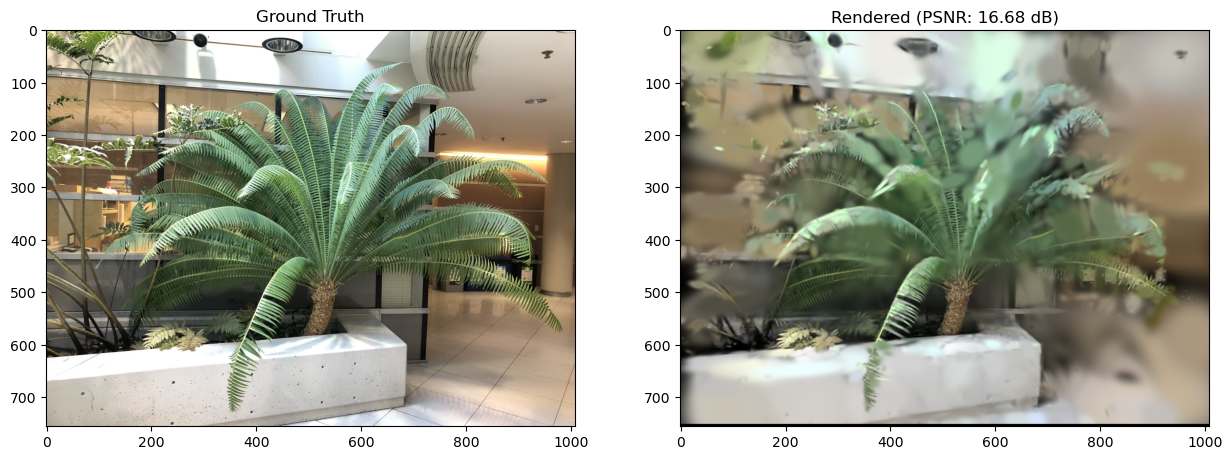

In [ ]:
# Render test view
test_sample = dataset[0]
with torch.no_grad():
    output = method.render(test_sample["camera"])
    rendered = output["image"]

gt = load_image_tensor(test_sample["image_path"], device=device)
psnr = compute_psnr(rendered, gt)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(tensor_to_image(gt))
axes[0].set_title('Ground Truth')
axes[1].imshow(tensor_to_image(rendered))
axes[1].set_title(f'Rendered (PSNR: {psnr:.2f} dB)')
plt.show()